In [2]:
!pip install --upgrade mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 43.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [3]:
import os
import shutil
import cv2
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Use non-GUI backend
import matplotlib.pyplot as plt
from skimage.morphology import binary_closing, binary_opening, disk
import mediapipe as mp
from sklearn.cluster import KMeans

def evaluate_segmentation(pred_mask, gt_mask):
    """
    Evaluate segmentation using Jaccard Index (IoU) and Dice Coefficient
    """
    # Ensure binary masks
    pred_mask_bin = pred_mask > 0
    gt_mask_bin = gt_mask > 0
    
    # Calculate Intersection and Union for IoU
    intersection = np.logical_and(pred_mask_bin, gt_mask_bin).sum()
    union = np.logical_or(pred_mask_bin, gt_mask_bin).sum()
    
    # Calculate Dice Score
    dice_score = (2 * intersection) / (np.sum(pred_mask_bin) + np.sum(gt_mask_bin)) if (np.sum(pred_mask_bin) + np.sum(gt_mask_bin)) > 0 else 0
    
    # Calculate IoU
    iou_score = intersection / union if union > 0 else 0
    
    return iou_score, dice_score

def detect_face_landmarks(image):
    """
    Detect face landmarks using MediaPipe to locate mouth and nose area
    """
    mp_face_mesh = mp.solutions.face_mesh
    
    # Initialize face mesh detector
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
        
        # Convert the BGR image to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image
        results = face_mesh.process(rgb_image)
        
        if not results.multi_face_landmarks:
            return None
        
        # Get facial landmarks
        landmarks = results.multi_face_landmarks[0].landmark
        
        # Extract mouth and nose region landmarks
        # MediaPipe provides indices for different facial landmarks
        # Approximate indices for nose and mouth region
        nose_indices = list(range(1, 6)) + list(range(195, 200))
        mouth_indices = list(range(0, 17)) + list(range(61, 69)) + list(range(291, 300))
        
        # Combine relevant indices
        relevant_indices = nose_indices + mouth_indices
        
        # Get the coordinates
        h, w, _ = image.shape
        mask_region_points = []
        
        for idx in relevant_indices:
            if idx < len(landmarks):
                x, y = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
                mask_region_points.append((x, y))
        
        return mask_region_points

def create_mask_region_from_landmarks(image, landmarks):
    """
    Create an improved ROI around the mouth and nose
    """
    if not landmarks:
        return np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    # Create a mask from the landmarks
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    # Convert landmarks to numpy array
    points = np.array(landmarks, dtype=np.int32)
    
    # Calculate convex hull
    hull = cv2.convexHull(points)
    
    # Get bounding rectangle and expand it
    x, y, w, h = cv2.boundingRect(hull)
    
    # Expand ROI by 40% to ensure it covers the mask area
    expanded_x = max(0, int(x - 0.2 * w))
    expanded_y = max(0, int(y - 0.2 * h))
    expanded_w = min(image.shape[1] - expanded_x, int(w * 1.4))
    expanded_h = min(image.shape[0] - expanded_y, int(h * 1.4))
    
    # Create expanded mask
    cv2.rectangle(mask, (expanded_x, expanded_y), 
                 (expanded_x + expanded_w, expanded_y + expanded_h), 255, -1)
    
    return mask

def multi_color_segmentation(image, roi_mask):
    """
    Improved color segmentation for face masks
    """
    # Apply ROI
    roi_image = cv2.bitwise_and(image, image, mask=roi_mask)
    
    # Extract pixels within ROI for clustering
    h, w = roi_mask.shape
    pixels = []
    coords = []
    
    for y in range(h):
        for x in range(w):
            if roi_mask[y, x] > 0:
                pixels.append(image[y, x])
                coords.append((y, x))
    
    if not pixels:
        return np.zeros_like(roi_mask, dtype=np.uint8)  # Ensure uint8 type
    
    # Reshape for clustering
    pixels = np.array(pixels)
    
    # Use K-means clustering to segment different colors
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Score each cluster for "mask-likeness"
    cluster_scores = []
    cluster_masks = []
    
    # Convert centers to HSV for better color analysis
    centers = kmeans.cluster_centers_
    centers_hsv = [cv2.cvtColor(np.uint8([[center]]), cv2.COLOR_BGR2HSV)[0][0] for center in centers]
    
    for i in range(n_clusters):
        # Create mask for this cluster
        cluster_mask = np.zeros_like(roi_mask, dtype=np.uint8)  # Ensure uint8 type
        cluster_indices = [idx for idx, label in enumerate(labels) if label == i]
        
        # Populate mask
        for idx in cluster_indices:
            y, x = coords[idx]
            cluster_mask[y, x] = 255
        
        # Apply morphological closing to make mask more coherent
        cluster_mask = binary_closing(cluster_mask, disk(3)).astype(np.uint8) * 255  # Convert bool to uint8
        cluster_masks.append(cluster_mask)
        
        # Score based on HSV values and cluster size
        h, s, v = centers_hsv[i]
        
        # Masks are often blue, white, black, or other distinctive colors
        # Avoid skin tones (reddish-yellow hues)
        is_skin_tone = (0 <= h <= 30) or (h >= 170) and (s >= 30)
        color_score = 0.7 if not is_skin_tone else 0.3
        
        # Size relative to ROI (not too small, not too large)
        size = np.sum(cluster_mask > 0)
        roi_size = np.sum(roi_mask > 0)
        size_ratio = size / roi_size if roi_size > 0 else 0
        size_score = 0.8 if 0.1 <= size_ratio <= 0.7 else 0.2
        
        # Consider position (masks are usually in middle of face)
        y_indices, x_indices = np.where(cluster_mask > 0)
        if len(y_indices) > 0:
            # Fix divide by zero error by checking if h is non-zero
            center_y = np.mean(y_indices) / h if h > 0 else 0.5
            position_score = 0.8 if 0.3 <= center_y <= 0.7 else 0.3
        else:
            position_score = 0
        
        total_score = (color_score * 0.5) + (size_score * 0.3) + (position_score * 0.2)
        cluster_scores.append((i, total_score))
    
    # Sort by score and get best cluster
    cluster_scores.sort(key=lambda x: x[1], reverse=True)
    best_cluster = cluster_scores[0][0]
    
    return cluster_masks[best_cluster]

def texture_based_segmentation(image, roi_mask):
    """
    Use texture analysis to detect mask regions within ROI
    """
    # Apply ROI
    roi_image = cv2.bitwise_and(image, image, mask=roi_mask)
    
    # Convert to grayscale
    gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive thresholding to find texture differences
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Only keep texture within ROI
    texture_mask = cv2.bitwise_and(binary, binary, mask=roi_mask)
    
    return texture_mask

def post_process_mask(mask, roi_mask):
    """
    Improved post-processing for cleaner results
    """
    # Apply ROI constraint
    mask = cv2.bitwise_and(mask, mask, mask=roi_mask)
    
    # First try morphological operations to clean up
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return mask
    
    # Sort contours by area, largest first
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Create a new mask with only the significant contours
    filtered_mask = np.zeros_like(mask)
    roi_area = np.sum(roi_mask > 0)
    
    # Keep contours that are significant in size
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > (roi_area * 0.05):  # Lower threshold to 5%
            cv2.drawContours(filtered_mask, [contour], -1, 255, -1)
    
    # If no significant contours were found, return the original mask
    if np.sum(filtered_mask) == 0:
        return mask
    
    return filtered_mask

def invert_if_needed(pred_mask, gt_mask):
    """
    Check if the mask needs to be inverted by comparing IoU with ground truth
    """
    iou_original = evaluate_segmentation(pred_mask, gt_mask)
    iou_inverted = evaluate_segmentation(255 - pred_mask, gt_mask)
    
    if iou_inverted > iou_original:
        return 255 - pred_mask
    return pred_mask

def segment_face_mask(image, gt_mask=None):
    """
    Improved mask segmentation combining color and texture
    """
    # Step 1: Detect face landmarks to create ROI
    landmarks = detect_face_landmarks(image)
    
    if not landmarks:
        # Fallback to using the center of the image as ROI
        h, w = image.shape[:2]
        roi_mask = np.zeros((h, w), dtype=np.uint8)
        roi_x, roi_y = w // 4, h // 4
        roi_w, roi_h = w // 2, h // 2
        cv2.rectangle(roi_mask, (roi_x, roi_y), (roi_x + roi_w, roi_y + roi_h), 255, -1)
    else:
        # Create ROI from landmarks
        roi_mask = create_mask_region_from_landmarks(image, landmarks)
    
    # Step 2: Color segmentation
    color_mask = multi_color_segmentation(image, roi_mask)
    
    # Step 3: Texture segmentation
    texture_mask = texture_based_segmentation(image, roi_mask)
    
    # Step 4: Combine results - Fixed type issue
    # Convert masks to uint8 to avoid type errors in addWeighted
    color_mask_uint8 = color_mask.astype(np.uint8)
    texture_mask_uint8 = texture_mask.astype(np.uint8)
    
    # Now combine them
    combined_mask = cv2.addWeighted(color_mask_uint8, 0.7, texture_mask_uint8, 0.3, 0)
    _, combined_mask = cv2.threshold(combined_mask, 100, 255, cv2.THRESH_BINARY)
    
    # Step 5: Post-process
    final_mask = post_process_mask(combined_mask, roi_mask)
    
    # Step 6: Invert if needed
    if gt_mask is not None:
        final_mask = invert_if_needed(final_mask, gt_mask)
    
    return final_mask, roi_mask

def main():
    # Define input and output directories
    input_dir = '/kaggle/input/mask-segmentation-mini/50_masked_faces'
    gt_dir = '/kaggle/input/mask-segmentation/1/face_crop_segmentation'
    output_dir = 'traditional_segmented_outputs'
    
    # Delete the output directory if it exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    # Create fresh output directory
    os.makedirs(output_dir)
    
    # Initialize lists to store evaluation metrics
    iou_scores = []
    dice_scores = []
    
    # Process each image
    for filename in os.listdir(input_dir):
        if not filename.endswith(('.jpg', '.jpeg', '.png')):
            continue
        
        try:
            # Read input image and ground truth
            img_path = os.path.join(input_dir, filename)
            gt_path = os.path.join(gt_dir, filename)
            
            if not os.path.exists(gt_path):
                print(f"Ground truth not found for {filename}, skipping.")
                continue
            
            image = cv2.imread(img_path)
            gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None or gt_mask is None:
                print(f"Could not read image or ground truth for {filename}, skipping.")
                continue
            
            # Apply segmentation
            final_mask, roi_mask = segment_face_mask(image, gt_mask)
            
            # Evaluate segmentation (IoU & Dice)
            iou, dice = evaluate_segmentation(final_mask, gt_mask)
            iou_scores.append(iou)
            dice_scores.append(dice)
            
            # Save segmentation results
            mask_output_path = os.path.join(output_dir, f'mask_{filename}')
            cv2.imwrite(mask_output_path, final_mask)
            
            print(f"Processed {filename} - IoU: {iou:.4f}, Dice: {dice:.4f}")
        
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            import traceback
            traceback.print_exc()  # Print detailed traceback for debugging
    
    # Save summary report
    if iou_scores:
        avg_iou = np.mean(iou_scores)
        avg_dice = np.mean(dice_scores)
        
        with open(os.path.join(output_dir, 'segmentation_results.txt'), 'w') as f:
            f.write("Mask Segmentation Results\n")
            f.write("========================\n")
            f.write(f"Total images processed: {len(iou_scores)}\n")
            f.write(f"Average IoU (Jaccard Index): {avg_iou:.4f}\n")
            f.write(f"Average Dice Score: {avg_dice:.4f}\n")
            f.write(f"Min IoU: {np.min(iou_scores):.4f}, Max IoU: {np.max(iou_scores):.4f}\n")
            f.write(f"Min Dice: {np.min(dice_scores):.4f}, Max Dice: {np.max(dice_scores):.4f}\n")
            f.write(f"Standard Deviation IoU: {np.std(iou_scores):.4f}\n")
            f.write(f"Standard Deviation Dice: {np.std(dice_scores):.4f}\n")
        
        print(f"\nSummary saved to segmentation_results.txt - Avg IoU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")
    else:
        print("No images were successfully processed.")


if __name__ == "__main__":
    main()

Processed 006869_1.jpg - IoU: 0.5147, Dice: 0.6796
Processed 007473_4.jpg - IoU: 0.5906, Dice: 0.7426
Processed 006373_1.jpg - IoU: 0.8879, Dice: 0.9406
Processed 006621_1.jpg - IoU: 0.6232, Dice: 0.7679
Processed 006751_3.jpg - IoU: 0.2889, Dice: 0.4483
Processed 006985_1.jpg - IoU: 0.3200, Dice: 0.4849
Processed 007923_1.jpg - IoU: 0.5214, Dice: 0.6854
Processed 006725_1.jpg - IoU: 0.4746, Dice: 0.6437
Processed 002248_1.jpg - IoU: 0.4968, Dice: 0.6638
Processed 007511_1.jpg - IoU: 0.5925, Dice: 0.7441
Processed 007055_1.jpg - IoU: 0.3243, Dice: 0.4898
Processed 001077_2.jpg - IoU: 0.7204, Dice: 0.8375
Processed 001438_4.jpg - IoU: 0.7423, Dice: 0.8521
Processed 000051_1.jpg - IoU: 0.4475, Dice: 0.6183
Processed 007826_2.jpg - IoU: 0.3872, Dice: 0.5583
Processed 005929_1.jpg - IoU: 0.5177, Dice: 0.6822
Processed 000060_1.jpg - IoU: 0.4248, Dice: 0.5963
Processed 007008_3.jpg - IoU: 0.4299, Dice: 0.6013
Processed 007907_1.jpg - IoU: 0.8046, Dice: 0.8917
Processed 006247_1.jpg - IoU: 0

Loading and preprocessing data...


100%|██████████| 50/50 [00:00<00:00, 84.16it/s]


Training data shape: (40, 128, 128, 3), (40, 128, 128, 1)
Validation data shape: (10, 128, 128, 3), (10, 128, 128, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 512)    │              0 │ dropout[0][0]          │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 768)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,769,728 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 12s/step - accuracy: 0.6541 - loss: 0.6766 - mean_io_u: 0.3370 - val_accuracy: 0.6949 - val_loss: 0.6393 - val_mean_io_u: 0.3474
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6685 - loss: 0.8785 - mean_io_u: 0.3342 - val_accuracy: 0.6949 - val_loss: 0.6615 - val_mean_io_u: 0.3474
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6628 - loss: 0.6629 - mean_io_u: 0.3314 - val_accuracy: 0.6949 - val_loss: 0.6473 - val_mean_io_u: 0.3474
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6705 - loss: 0.6420 - mean_io_u: 0.3353 - val_accuracy: 0.6949 - val_loss: 0.6611 - val_mean_io_u: 0.3474
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.6643 - loss: 0.6485 - mean_io_u: 0.3322 - val_accuracy: 0.6949 - val_loss: 0.6047 - val_mean_io_u: 0.3474
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.6681 - loss: 0.5932 - mean_io_u: 0.3334 - val_accuracy: 0.6949 - val_

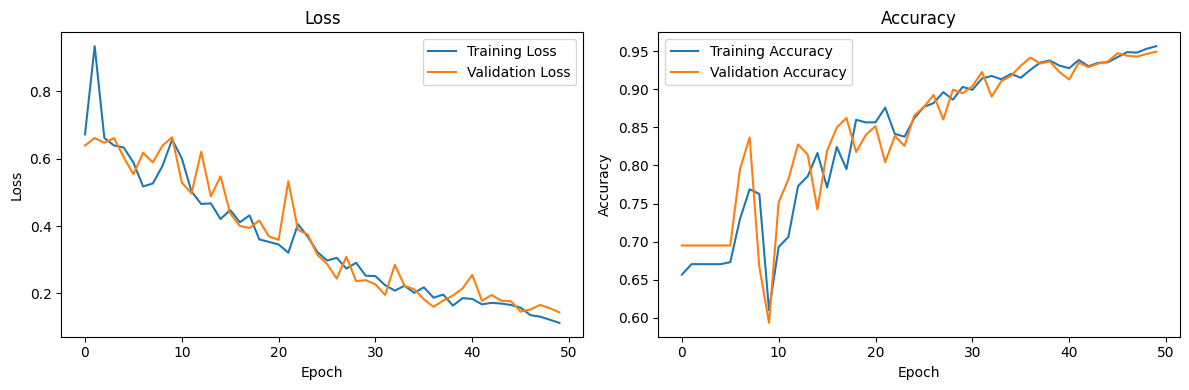

Evaluating model on validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Validation Metrics:
Accuracy: 0.9494
Dice Score: 0.9172
IoU Score: 0.8470
Generating predictions for all images...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1it [00:03,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


3it [00:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


5it [00:03,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


7it [00:03,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


9it [00:03,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:04,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


13it [00:04,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


15it [00:04,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


17it [00:04, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


19it [00:04, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


21it [00:04,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:05,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


25it [00:05, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


27it [00:05, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


29it [00:05, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


31it [00:05, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


33it [00:05, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


35it [00:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


37it [00:06, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


39it [00:06, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


41it [00:06,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


43it [00:06, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


45it [00:06, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


47it [00:06, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


49it [00:07, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


50it [00:07,  7.06it/s]


Results Summary:
Average Accuracy: 0.9568
Average Dice Score: 0.9273
Average IoU Score: 0.8730


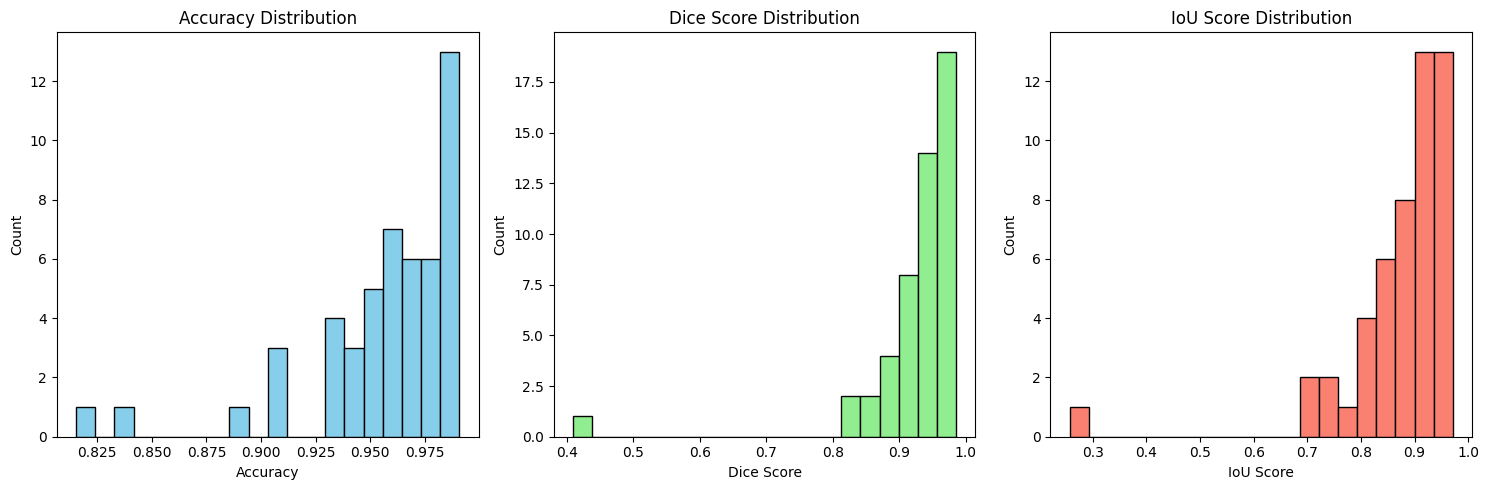

All segmentation outputs and evaluation results saved to segmented_outputs


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import cv2
from tqdm import tqdm
import pandas as pd

# Set paths
input_dir = "/kaggle/input/mask-segmentation/1/face_crop"
mask_dir = "/kaggle/input/mask-segmentation/1/face_crop_segmentation"
output_dir = "segmented_outputs"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get list of images
image_names = os.listdir(input_dir)
image_paths = [os.path.join(input_dir, name) for name in image_names]
mask_paths = [os.path.join(mask_dir, name) for name in image_names]

# Filter to make sure both image and mask exist
valid_pairs = []
for img_path, mask_path in zip(image_paths, mask_paths):
    if os.path.exists(img_path) and os.path.exists(mask_path):
        valid_pairs.append((img_path, mask_path))

image_paths, mask_paths = zip(*valid_pairs)

# Define image dimensions
img_height = 128
img_width = 128

# Load and preprocess data
def load_data(image_paths, mask_paths):
    images = []
    masks = []
    
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        # Load image and resize
        img = load_img(img_path, target_size=(img_height, img_width))
        img = img_to_array(img) / 255.0  # Normalize to [0,1]
        
        # Load mask and resize
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)  # Binarize mask
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

print("Loading and preprocessing data...")
X, y = load_data(image_paths, mask_paths)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    
    # Decoder
    up5 = concatenate([UpSampling2D(size=(2, 2))(drop4), conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile model
model = unet_model()
model.compile(
    optimizer=Adam(learning_rate=1e-3),  
    loss='binary_crossentropy',
    metrics=['accuracy', MeanIoU(num_classes=2)]
)

model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('unet_face_mask.keras', 
                             monitor='val_loss', 
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)

# Train model
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Calculate IOU, Dice Score and Accuracy on validation set
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    
    # Calculate metrics
    accuracy = np.mean(y_true == y_pred_binary)
    dice = dice_coef(y_true, y_pred_binary)
    iou = iou_coef(y_true, y_pred_binary)
    
    return accuracy, dice, iou

# Evaluate on validation set
print("Evaluating model on validation set...")
validation_predictions = model.predict(X_val)
val_accuracy, val_dice, val_iou = calculate_metrics(y_val, validation_predictions)

print(f"Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Dice Score: {val_dice:.4f}")
print(f"IoU Score: {val_iou:.4f}")

# Generate and save predictions for all images
print("Generating predictions for all images...")
results = []

for i, (img_path, mask_path) in enumerate(tqdm(zip(image_paths, mask_paths))):
    # Original filename without path
    filename = os.path.basename(img_path)
    
    # Load image
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    
    # Predict mask
    pred_mask = model.predict(np.expand_dims(img_array, axis=0))[0]
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255
    
    # Load ground truth for comparison
    true_mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
    true_mask_array = img_to_array(true_mask) / 255.0
    true_mask_binary = (true_mask_array > 0.5).astype(np.float32)
    
    # Calculate metrics
    acc, dice, iou = calculate_metrics(true_mask_binary, pred_mask)
    results.append({
        'filename': filename,
        'accuracy': acc,
        'dice_score': dice,
        'iou_score': iou
    })
    
    # Save the prediction
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, pred_mask_binary.squeeze())
    
    # Visualize comparison (original, true mask, predicted mask) for random samples
    if i % 20 == 0:  # Sample some images for visualization
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask_array.squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title(f'Prediction\nIoU: {iou:.4f}, Dice: {dice:.4f}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'comparison_{filename}'))
        plt.close()

# Compile results into DataFrame and save
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(f"Average Accuracy: {results_df['accuracy'].mean():.4f}")
print(f"Average Dice Score: {results_df['dice_score'].mean():.4f}")
print(f"Average IoU Score: {results_df['iou_score'].mean():.4f}")

# Save metrics to CSV
results_df.to_csv(os.path.join(output_dir, 'segmentation_metrics.csv'), index=False)

# Plot distribution of metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(results_df['accuracy'], bins=20, color='skyblue', edgecolor='black')
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(results_df['dice_score'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Dice Score Distribution')
plt.xlabel('Dice Score')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(results_df['iou_score'], bins=20, color='salmon', edgecolor='black')
plt.title('IoU Score Distribution')
plt.xlabel('IoU Score')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'metrics_distribution.png'))
plt.show()

print(f"All segmentation outputs and evaluation results saved to {output_dir}")